<a href="https://colab.research.google.com/github/rajvi08/PROJECT-1/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DESIGN 6197/4197 | AI & Design: Generative AI from MLPs to APIs
## Homework 2 | Introduction to Convolutional Neural Networks (CNNs) and Generative Models | 15 Points Total

*Adapted from 4.453x Creative Machine Learning for Design @ MIT | Instructors: Renaud Danhaive, Ous Abou Ras, Natasha Hirt, and Caitlin Mueller*

This notebook is split into two parts. First, you will build a simple CNN for classifying digits. Then you will use convolutional layers in autoencoder (AE) and variational autoencoder (VAE) network architectures trained on the MNIST dataset. We use MNIST so we can focus on architecture considerations.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
!pip install torchinfo
import torchinfo
from torchinfo import summary
from tqdm import tqdm
import scipy.stats

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Your computations will be done on {device}")

Your computations will be done on cuda


### Part 1: Convolutional Neural Networks

In this section of the assignment you will re-implement [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

![LeNet-5](imgs/lenet-5.png)

The goal of this network is to take in an image of a handwritten digit and predict the value of the digit. You performed a very similar task in HW1, but this time you will be defining a **convolutional neural network** or CNN to perform this classification task.

#### Load data

The first thing you need to do is to download the MNIST datasets for testing and training. In this step you will also need to do some transformations to the dataset to prepare it for use in training your model. The images in the MNIST dataset are 28x28 pixels, however in LeNet5, they start with a slightly larger 32x32 pixel image input so you will need to resize this images. You also need to convert the image to a tensor. Then finally, you need to normalize the dataset. The mean of the pixel values in the training set is 0.1307 and standard deviation is 0.3081.

To get the images up to the 32x32 pixel size you can use the [transforms.Resize()](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) function, then you can use [transforms.ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html), and finally you can use [transforms.Normalize()](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) with the given mean and standard deviation values to normalize the dataset. These transformations can be collected together using [transforms.Compose()](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html). (1 pt)

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32, 32), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])



# Load the MNIST dataset
mnist_training_set = torchvision.datasets.MNIST(
    "data", train=True, download=True, transform=transform
)
mnist_validation_set = torchvision.datasets.MNIST(
    "data", train=False, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14872646.98it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 516627.40it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3936811.59it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10160282.01it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Next you will create the dataloader for the training set and the validation set. Make sure you set shuffle to `True`. (1 pt)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

training_dataloader = DataLoader(mnist_training_set, batch_size, shuffle=True)
validation_dataloader =  DataLoader(mnist_validation_set, batch_size, shuffle=True)

Now you will define the architecture of the LeNet5 model. In order to complete this section I will refer you to the paper on LeNet5 (https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) to determine the size of the kernels. On pages 7 and 8 of the PDF there is a description of the model architecture which refers to these kernels as 'neighborhoods' of the feature maps. The number of input and output channels for each piece of the network can be determined from the model architecture diagram at the top of the assignment (which comes from the linked paper). Replace all of the _ with the correct values. (3 pts)

In [ ]:
class LeNet_5(torch.nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh())

        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 120)
        x = self.fc(x)

        return x

Instantiate the LeNet5 model. Make sure to send it .to(device) (1 point)

In [ ]:
model = LeNet_5().to(device)

In [ ]:
#Check that all the parameters are on the same device
for layer in model.parameters():
    print(layer.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [ ]:
summary(model, input_size=(batch_size, 1, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_5                                  [64, 10]                  --
├─Sequential: 1-1                        [64, 120, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─Tanh: 2-2                         [64, 6, 28, 28]           --
│    └─AvgPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─Tanh: 2-5                         [64, 16, 10, 10]          --
│    └─AvgPool2d: 2-6                    [64, 16, 5, 5]            --
│    └─Conv2d: 2-7                       [64, 120, 1, 1]           48,120
│    └─Tanh: 2-8                         [64, 120, 1, 1]           --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-9                       [64, 84]                  10,164
│    └─Tanh: 2-10                        [64, 84]                  --
│  

In [ ]:
#No need to write code here, just run this cell.
loss_fn = nn.CrossEntropyLoss() #This will automatically apply a softmax function to the model's output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Here we again have our familiar training loop.

In [10]:
n_epochs = 10

train_loss_history = []
train_accuracy_history = []

validation_loss_history = []
validation_accuracy_history = []

n_train_examples = len(training_dataloader)  # number of training batches
n_validation_examples = len(validation_dataloader)  # number of validation batches

for i in tqdm(range(n_epochs)):
    print(f"----- Epoch {i} -----")

    # --- VALIDATION ---
    validation_loss = 0
    validation_accuracy = 0

    for sample in validation_dataloader:
        image, target_class = sample

        # model predictions
        predictions = model(image.to(device))

        # compute loss
        validation_loss += (loss_fn(predictions,
                            target_class.to(device),
                            ) / n_validation_examples)

        # compute accuracy
        class_predictions = torch.argmax(predictions, axis=1)
        validation_accuracy += (torch.count_nonzero(class_predictions == target_class.to(device))
                                / batch_size
                                / n_validation_examples
                                )

    validation_loss_history.append(validation_loss.item())
    validation_accuracy_history.append(validation_accuracy.item())

    # --- TRAINING ---
    loss = 0
    accuracy = 0

    for sample in tqdm(training_dataloader):
        image, target_class = sample

        # model predictions
        predictions = model(image.to(device))

        batch_loss = loss_fn(predictions,
                             target_class.to(device),
                             )

        # backprop + gradient descent step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # compute loss
        loss += batch_loss / n_train_examples

        # compute accuracy
        class_predictions = torch.argmax(predictions, axis=1)
        accuracy += (torch.count_nonzero(class_predictions == target_class.to(device))
                    / batch_size
                    / n_train_examples)

    train_loss_history.append(loss.item())
    train_accuracy_history.append(accuracy.item())

    print(f"Training - Mean loss: {loss} | Accuracy: {int(accuracy*100)}%")
    print(f"Validation at epoch start - Mean loss: {validation_loss} | Accuracy: {int(validation_accuracy*100)}%")

  0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 0 -----



 10%|█         | 1/10 [00:24<03:40, 24.49s/it]

Training - Mean loss: 0.24349941313266754 | Accuracy: 93%
Validation at epoch start - Mean loss: 2.303694486618042 | Accuracy: 19%
----- Epoch 1 -----



 20%|██        | 2/10 [00:48<03:11, 23.96s/it]

Training - Mean loss: 0.07179860770702362 | Accuracy: 97%
Validation at epoch start - Mean loss: 0.09570536762475967 | Accuracy: 96%
----- Epoch 2 -----



 30%|███       | 3/10 [01:12<02:48, 24.14s/it]

Training - Mean loss: 0.05081571266055107 | Accuracy: 98%
Validation at epoch start - Mean loss: 0.05482034012675285 | Accuracy: 97%
----- Epoch 3 -----



 40%|████      | 4/10 [01:36<02:24, 24.08s/it]

Training - Mean loss: 0.0392552874982357 | Accuracy: 98%
Validation at epoch start - Mean loss: 0.046764302998781204 | Accuracy: 98%
----- Epoch 4 -----



 50%|█████     | 5/10 [02:00<02:00, 24.11s/it]

Training - Mean loss: 0.03150356188416481 | Accuracy: 98%
Validation at epoch start - Mean loss: 0.041900813579559326 | Accuracy: 98%
----- Epoch 5 -----



 60%|██████    | 6/10 [02:25<01:36, 24.23s/it]

Training - Mean loss: 0.02602648176252842 | Accuracy: 99%
Validation at epoch start - Mean loss: 0.04420902207493782 | Accuracy: 98%
----- Epoch 6 -----



 70%|███████   | 7/10 [02:48<01:12, 24.14s/it]

Training - Mean loss: 0.023557642474770546 | Accuracy: 99%
Validation at epoch start - Mean loss: 0.04379934445023537 | Accuracy: 98%
----- Epoch 7 -----



 80%|████████  | 8/10 [03:12<00:48, 24.07s/it]

Training - Mean loss: 0.017945436760783195 | Accuracy: 99%
Validation at epoch start - Mean loss: 0.04040652513504028 | Accuracy: 98%
----- Epoch 8 -----



 90%|█████████ | 9/10 [03:37<00:24, 24.20s/it]

Training - Mean loss: 0.017262892797589302 | Accuracy: 99%
Validation at epoch start - Mean loss: 0.045717786997556686 | Accuracy: 98%
----- Epoch 9 -----



100%|██████████| 10/10 [04:01<00:00, 24.18s/it]

Training - Mean loss: 0.013051136396825314 | Accuracy: 99%
Validation at epoch start - Mean loss: 0.03995780646800995 | Accuracy: 98%


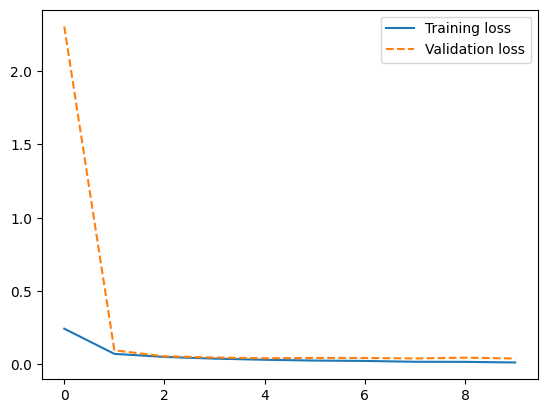

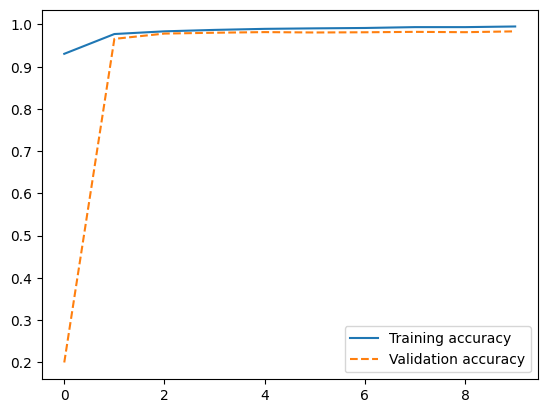

In [11]:
plt.plot(train_loss_history, label="Training loss")
plt.plot(validation_loss_history, linestyle="--", label="Validation loss")
plt.legend()
plt.show()
plt.plot(train_accuracy_history, label="Training accuracy")
plt.plot(validation_accuracy_history, linestyle="--", label="Validation accuracy")
plt.legend()
plt.show()

In [12]:
images, observations = next(iter(validation_dataloader))
predicted = torch.argmax(model(images.to(device)), axis=-1)

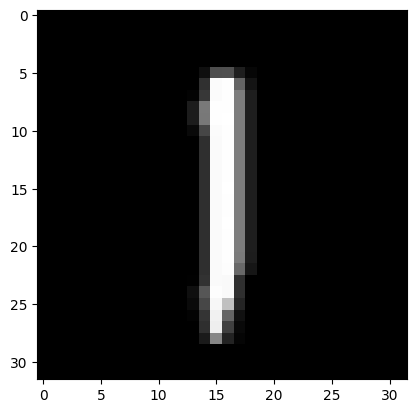

The actual digit is 1.
The predicted digit is 1.


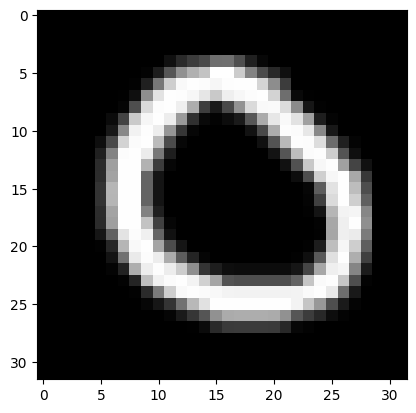

The actual digit is 0.
The predicted digit is 0.


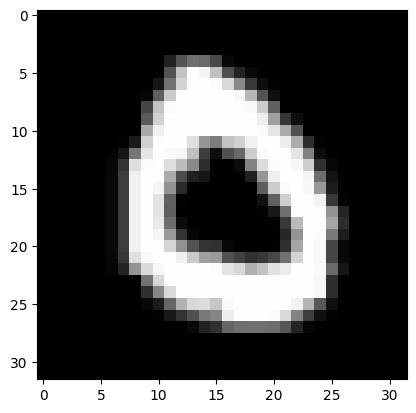

The actual digit is 0.
The predicted digit is 0.


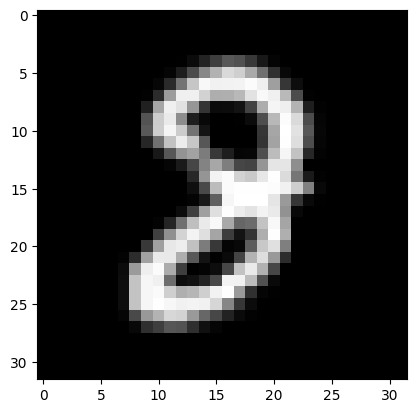

The actual digit is 8.
The predicted digit is 8.


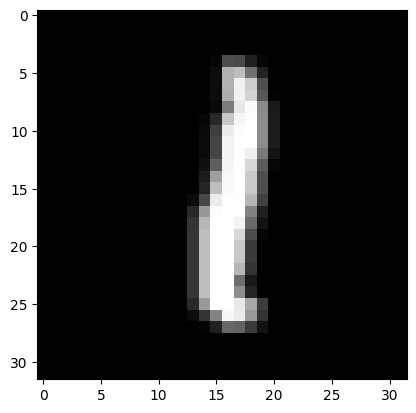

The actual digit is 1.
The predicted digit is 1.


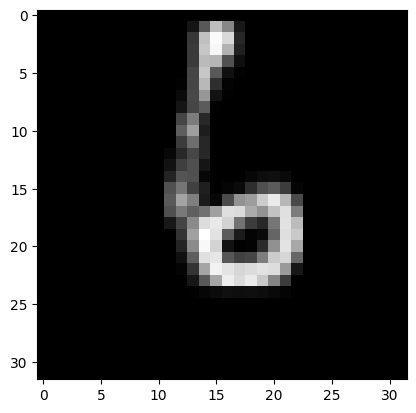

The actual digit is 6.
The predicted digit is 6.


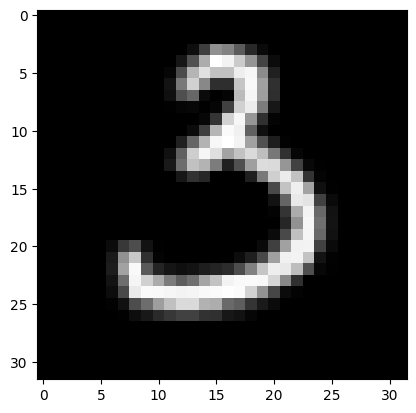

The actual digit is 3.
The predicted digit is 3.


In [13]:
for i, (img, digit, pred) in enumerate(zip(images, observations, predicted)):
    plt.imshow(img[0], cmap="gray")
    plt.grid(False)
    plt.show()
    print(f"The actual digit is {int(digit)}.")
    print(f"The predicted digit is {int(pred)}.")
    if i > 5:
        break

In [14]:
confusion_matrix = torch.zeros((10, 10))
digit_counts = torch.zeros(10)

for sample in validation_dataloader:
    image, target_class = sample

    # model predictions
    log_probabilities = model(image.to(device))

    # compute accuracy
    class_predictions = torch.argmax(log_probabilities, axis=1)

    for i, j in zip(target_class, class_predictions):
        confusion_matrix[i, j] += 1
        digit_counts[i] += 1  # count number of occurrences of each digit

confusion_matrix = confusion_matrix / digit_counts.reshape(-1, 1) * 100

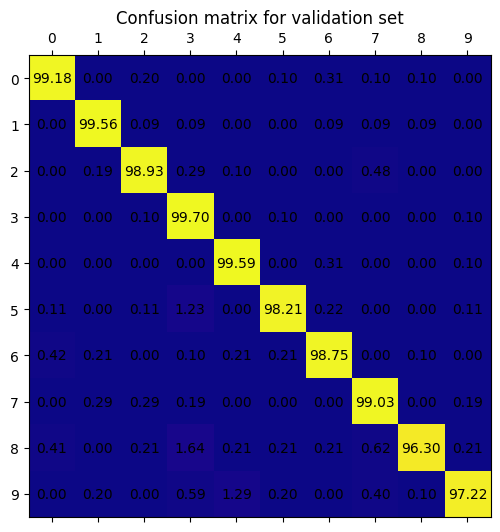

In [15]:
fig, ax = plt.subplots(figsize=(6, 6),)
plt.title("Confusion matrix for validation set")
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(confusion_matrix, cmap="plasma")

for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center")


ax.xaxis.set_ticks(range(10))
ax.yaxis.set_ticks(range(10))

plt.grid(False)
plt.show()

How does this compare to the confusion matrix you generated for your model in HW1? Answer in the markdown cell below. (1 pt)

When we compare both the confusion matrix, we can say that the model in HW2 is more accurate when compared with HW1.

In [16]:
del model, optimizer, loss_fn, training_dataloader, validation_dataloader, mnist_training_set, mnist_validation_set, transform

### Part 2

In this section we will get back into building simple generative models. These models will allow you to do some interpolation in the latent space of the model in order to generate new samples.

#### Building an Autoencoder

Let's build an autoencoder module. We can build the overall structure of the autoencoder and simply assume it is fed the encoder and decoder modules as arguments.

In [17]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

An autoencoder is as simple as that! That said, we do need to define the encoders and decoders. For this section you need to define the layers in the __init__ for the encoder (2 pts) and decoder (2 pts).

The encoder should have the following layers defined in __init__:

| Layer Type | In Channels | Out Channels | Kernel Size | Stride |
| ---------- | ----------- | ------------ | ----------- | ------ |
| Conv2d | 1 | 16 | (3,3) | (1,1) |
| Conv2d | 16 | 32 | (3,3) | (1,1) |
| MaxPool2d | |  | (2,2) | (2,2) |
| Conv2d | 32 | 64 | (3,3) | (1,1) |
| MaxPool2d | |  | (2,2) | (2,2) |
|Linear | 64 * 5 * 5 | 32 |  |  |
|Linear | 32 | Latent Dim |  |  |



In [18]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Encoder, self).__init__()

        self.conv_1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_1 = nn.Linear(64 * 5 * 5, 32)
        self.fc_2 = nn.Linear(32,latent_dimensionality)

    def forward(self, x):

        x = self.conv_1(x)  # 3x28x28 -> 16x26x26
        x = F.relu(x)
        x = self.conv_2(x)  # 16x26x26 -> 32x24x24
        x = F.relu(x)
        x = self.pool_1(x)  # 32x24x24 -> 32x12x12
        x = self.conv_3(x)  # 32x12x12 -> 64x10x10
        x = F.relu(x)
        x = self.pool_2(x)  # 64x10x10 -> 64x5x5
        x = x.view(x.shape[0], -1)  # flatten x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)

        return x




The decoder should have the following layers defined in __init__:

| Layer Type | In Channels | Out Channels | Kernel Size | Stride | Scale Factor | Padding |
| ---------- | ----------- | ------------ | ----------- | ------ | ------------ | ------- |
| Linear | Latent Dim | 32 |  |  | | |
| Linear | 32| 64 * 5 * 5 |  |  | | |
| UpsamplingNearest2d | |  |  |  | (2,2) | |
| Conv2d | 64 | 32 | (3,3) | (1,1)  |  | (2,2) |
| UpsamplingNearest2d | |  |  |  | (2,2) | |
| Conv2d | 32 | 16 | (3,3) | (1,1)  |  | (2,2) |
| Conv2d | 16 | 1 | (3,3) | (1,1)  |  | (2,2) |



In [19]:
# the decoder essentially mirrors the architecture of the encoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Decoder, self).__init__()

        self.fc_1 = nn.Linear(latent_dimensionality,32)
        self.fc_2 = nn.Linear(32,64 * 5 * 5)
        self.upsample_1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv_1 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=2)
        self.upsample_2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv_2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=2)
        self.conv_3 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=2)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = x.view(-1, 64, 5, 5)
        x = self.upsample_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.upsample_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = torch.sigmoid(x)  # squeeze pixel value between 0 and 1

        return x

Now you need to initialize your model. The AutoEncoder module takes two arguments, the Encoder() and Decoder(). You need to fill these in. (1 pt)

In [20]:
ae_model = AutoEncoder(Encoder(), Decoder()).to(device)

In [21]:
summary(ae_model, input_size=(1, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 28, 28]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 16, 26, 26]           160
│    └─Conv2d: 2-2                       [1, 32, 24, 24]           4,640
│    └─MaxPool2d: 2-3                    [1, 32, 12, 12]           --
│    └─Conv2d: 2-4                       [1, 64, 10, 10]           18,496
│    └─MaxPool2d: 2-5                    [1, 64, 5, 5]             --
│    └─Linear: 2-6                       [1, 32]                   51,232
│    └─Linear: 2-7                       [1, 2]                    66
├─Decoder: 1-2                           [1, 1, 28, 28]            --
│    └─Linear: 2-8                       [1, 32]                   96
│    └─Linear: 2-9                       [1, 1600]                 52,800
│    └─UpsamplingNearest2d: 2-10         [1, 64, 10, 10]           --

In [22]:
mnist_training_set = torchvision.datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_validation_set = torchvision.datasets.MNIST(
    "data", train=False, download=True, transform=transforms.ToTensor()
)

batch_size = 64

training_dataloader = torch.utils.data.DataLoader(
    mnist_training_set, shuffle=True, batch_size=batch_size
)
validation_dataloader = torch.utils.data.DataLoader(
    mnist_validation_set, shuffle=True, batch_size=batch_size
)

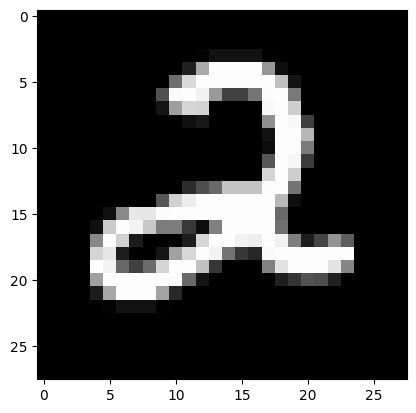

In [23]:
img = next(iter(training_dataloader))[0][0]
plt.imshow(img[0], cmap="gray")

In [24]:
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
reconstruction_loss = nn.BCELoss()

In [25]:
n_epochs = 20

for i in tqdm(range(n_epochs)):

    # training
    training_losses = []
    for sample in training_dataloader:
        optimizer.zero_grad()

        img, _ = sample
        img = img.to(device)
        #print(torch.min(img), torch.max(img))
        reconstructed = ae_model(img)
        loss = reconstruction_loss(reconstructed, img)
        #print(loss)

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())

    # validation
    validation_losses = []
    for digit_images, _ in validation_dataloader:
        digit_images = digit_images.to(device)
        reconstructed = ae_model(digit_images)
        loss = reconstruction_loss(reconstructed, digit_images)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )


  5%|▌         | 1/20 [00:13<04:13, 13.32s/it]

Epoch 0 | Mean training loss: 0.241 | Mean validation loss: 0.207


 10%|█         | 2/20 [00:26<04:02, 13.49s/it]

Epoch 1 | Mean training loss: 0.201 | Mean validation loss: 0.196


 15%|█▌        | 3/20 [00:40<03:51, 13.62s/it]

Epoch 2 | Mean training loss: 0.194 | Mean validation loss: 0.191


 20%|██        | 4/20 [00:53<03:31, 13.20s/it]

Epoch 3 | Mean training loss: 0.190 | Mean validation loss: 0.188


 25%|██▌       | 5/20 [01:05<03:14, 12.95s/it]

Epoch 4 | Mean training loss: 0.187 | Mean validation loss: 0.187


 30%|███       | 6/20 [01:18<02:58, 12.78s/it]

Epoch 5 | Mean training loss: 0.185 | Mean validation loss: 0.186


 35%|███▌      | 7/20 [01:30<02:45, 12.72s/it]

Epoch 6 | Mean training loss: 0.184 | Mean validation loss: 0.183


 40%|████      | 8/20 [01:43<02:31, 12.66s/it]

Epoch 7 | Mean training loss: 0.183 | Mean validation loss: 0.182


 45%|████▌     | 9/20 [01:55<02:18, 12.63s/it]

Epoch 8 | Mean training loss: 0.182 | Mean validation loss: 0.182


 50%|█████     | 10/20 [02:08<02:06, 12.62s/it]

Epoch 9 | Mean training loss: 0.181 | Mean validation loss: 0.182


 55%|█████▌    | 11/20 [02:21<01:53, 12.64s/it]

Epoch 10 | Mean training loss: 0.180 | Mean validation loss: 0.181


 60%|██████    | 12/20 [02:33<01:41, 12.65s/it]

Epoch 11 | Mean training loss: 0.180 | Mean validation loss: 0.181


 65%|██████▌   | 13/20 [02:46<01:28, 12.60s/it]

Epoch 12 | Mean training loss: 0.180 | Mean validation loss: 0.181


 70%|███████   | 14/20 [02:58<01:15, 12.56s/it]

Epoch 13 | Mean training loss: 0.179 | Mean validation loss: 0.180


 75%|███████▌  | 15/20 [03:11<01:02, 12.54s/it]

Epoch 14 | Mean training loss: 0.179 | Mean validation loss: 0.180


 80%|████████  | 16/20 [03:23<00:50, 12.51s/it]

Epoch 15 | Mean training loss: 0.178 | Mean validation loss: 0.179


 85%|████████▌ | 17/20 [03:36<00:37, 12.53s/it]

Epoch 16 | Mean training loss: 0.178 | Mean validation loss: 0.179


 90%|█████████ | 18/20 [03:49<00:25, 12.58s/it]

Epoch 17 | Mean training loss: 0.178 | Mean validation loss: 0.179


 95%|█████████▌| 19/20 [04:01<00:12, 12.58s/it]

Epoch 18 | Mean training loss: 0.178 | Mean validation loss: 0.179


100%|██████████| 20/20 [04:14<00:00, 12.70s/it]

Epoch 19 | Mean training loss: 0.177 | Mean validation loss: 0.179


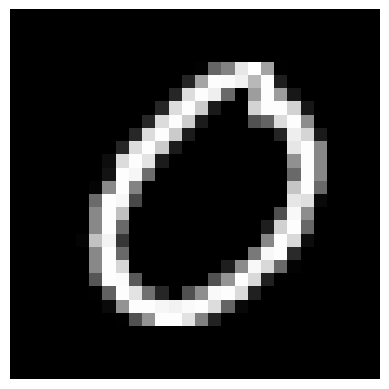

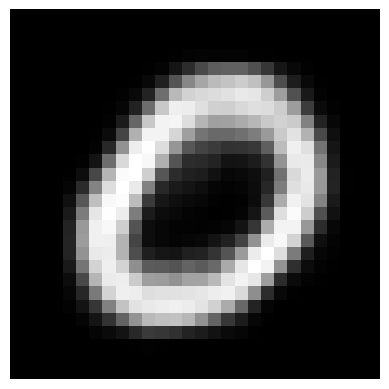

In [26]:
img_sample = next(iter(training_dataloader))[0].to(device)
i = 10
plt.imshow(img_sample.cpu()[i, 0], cmap="gray")
plt.axis("off")
plt.show()
plt.imshow(ae_model(img_sample).detach().cpu()[i, 0], cmap="gray")
plt.axis("off")
plt.show()

In [27]:
def get_all_encodings(model, dataloader):
    all_encoded = []
    all_labels = []
    for j, (digit_images, labels) in enumerate(dataloader):
        encoding = model.encoder(digit_images.to(device)).detach().cpu().numpy()
        all_encoded.append(encoding)
        all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    all_labels = np.concatenate(all_labels)
    return all_encoded, all_labels


def plot_mnist_encoding(model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of MNIST training set")
    all_encoded, all_labels = get_all_encodings(model, training_dataloader)
    training_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[0].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.2,
        cmap="plasma",
        label="Training",
    )

    ax[0].legend(*scatter.legend_elements(), loc="lower left", title="Labels")

    # Validation data
    ax[1].set_title(label="Encoding of MNIST validation set")
    all_encoded, all_labels = get_all_encodings(model, validation_dataloader)
    validation_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[1].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.5,
        marker="+",
        cmap="plasma",
    )

    ax[1].legend(*scatter.legend_elements(), title="Labels", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )
    ax[1].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )

    ax[0].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )
    ax[1].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )

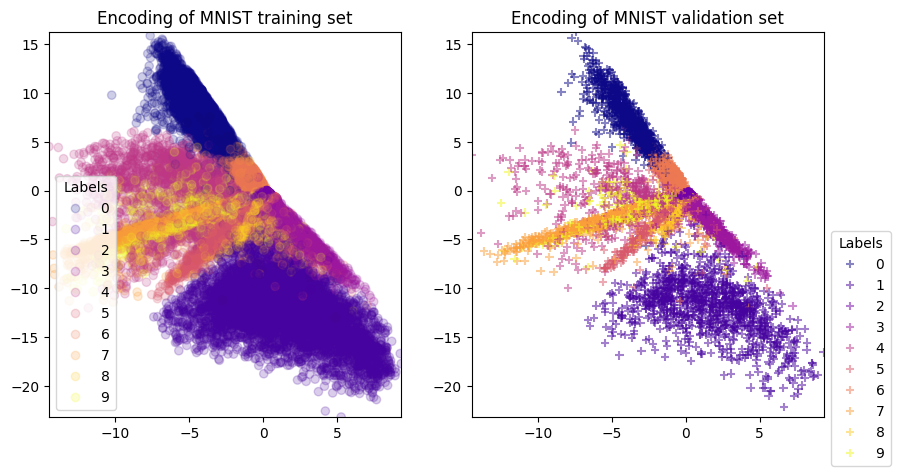

In [28]:
plot_mnist_encoding(ae_model)

The scatter plots of the encoded data above demonstrates that the encoder does a decent job at separating digits of different classes despite the extremely reduced dimensionality of the latent space. That said, the latent space is not necessarily meaningful. There are plenty of regions that are empty and the encoding does not follow a predictable structure making it difficult to use this latent space to generate samples.

To bring structure to the latent space, we need to enforce some sort of constraint over the structure of the latent space. This is where **Variational Autoencoders** (VAE) come in.

Let's save the model. All we have to do is save the so-called `state_dict` of the trained model, i.e. the model weights/parameters. We can then reload the model by simply loading it onto the model (as long as the model architecture is unchanged). This is the only thing we really need to save as long as we keep track of the architecture of the network we built. More details on saving models can be found in the [PyTorch documentation](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html)

In [29]:
saved_file_name = "mnist_ae_weights.pth"  # the extension does not matter
# Save learned parameters
torch.save(ae_model.state_dict(), saved_file_name)

In [30]:
# Load model parameters
reloaded_ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)
reloaded_ae_model.load_state_dict(torch.load(saved_file_name))
reloaded_ae_model.eval()

<ipython-input-30-082df31760b0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reloaded_ae_model.load_state_dict(torch.load(saved_file_name))


AutoEncoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_1): Linear(in_features=1600, out_features=32, bias=True)
    (fc_2): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=32, bias=True)
    (fc_2): Linear(in_features=32, out_features=1600, bias=True)
    (upsample_1): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (conv_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (upsample_2): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv_3)

## 3. Variational autoencoder
We have built a vanilla autoencoder. As we've seen, its latent space does not look amazing. Let's see if how the latent space of an equivalent variational autoencoder looks! There is actually very little to change here. The main difference between the autoencoder and the VAE is the introduction of a randomly sampled vector called **eps** here.

In [31]:
class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, encoder, decoder, latent_dimensionality):
        super(VariationalAutoEncoder, self).__init__(encoder, decoder)

        self.latent_dimensionality = latent_dimensionality

    def forward(self, x):
        x = self.encoder(x)
        mu = x[:, : self.latent_dimensionality]
        log_variance = x[:, self.latent_dimensionality :]
        # sample
        variance = torch.exp(log_variance)
        eps = torch.randn_like(variance)
        sample = mu + torch.sqrt(variance) * eps

        x = self.decoder(sample)
        return x, mu, log_variance

In [32]:
def kl_divergence(mu, log_variance):
    return 0.5 * torch.mean(mu ** 2 + torch.exp(log_variance) - (1 + log_variance))

reconstruction_loss = nn.BCELoss()

Here you need to define the vae_model. When you specify the Encoder() and Decoder() you will also need to provide arguments for the latent dimensionality. Now the encoder should have a latent dimensionality of 4. This will be double the latent dimensionality of the decoder. This is because the encoder will produce a mu and sigma for each component of the latent vector, z which has only two components. (1 point)

In [33]:
latent_dim = 4

encoder = Encoder(latent_dimensionality=latent_dim)
decoder = Decoder(latent_dimensionality=latent_dim // 2)

vae_model = VariationalAutoEncoder(encoder, decoder, 2).to(device)




In [34]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

The training loop always looks pretty much the same. However, now we have a composite loss term which has the reconstruction loss and the kl_divergence_loss terms added together. The kl_divergence also has a multiplier in front of it. This is a hyperparameter for the learning. You can adjust this if you like and see how it affects the distribution of the latent space. If you do adjust this parameter, make sure you run the cell where you define the vae_model again. This will reset all of the model weights. The weights are stored after you start the training loop and if you just continue training without resetting the model then you will be trying to improve on an already trained model.

In [35]:
n_epochs = 20
reporting_frequency = 200
for i in tqdm(range(1, n_epochs + 1)):

    # training
    training_losses = []
    for j, (digit_images, _) in enumerate(training_dataloader):
        optimizer.zero_grad()
        digit_images = digit_images.to(device)
        reconstructed, mu, log_variance = vae_model(digit_images)
        reconstruction = reconstruction_loss(reconstructed, digit_images)
        kl_divergence_loss = kl_divergence(mu, log_variance)

        loss = reconstruction + 0.01 * kl_divergence_loss

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j + 1, np.mean(training_losses)
                )
            )

    # validation
    validation_losses = []
    for j, (digit_images, _) in enumerate(validation_dataloader):
        digit_images = digit_images.to(device)
        reconstructed, _, _ = vae_model(digit_images)
        loss = reconstruction_loss(reconstructed, digit_images)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training total loss: {1:.3f} | Mean validation reconstruction loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Mean training loss after 200 batches: 0.326
Epoch 1 | Mean training loss after 400 batches: 0.289
Epoch 1 | Mean training loss after 600 batches: 0.274
Epoch 1 | Mean training loss after 800 batches: 0.267


  5%|▌         | 1/20 [00:13<04:11, 13.25s/it]

Epoch 1 | Mean training total loss: 0.263 | Mean validation reconstruction loss: 0.233
Epoch 2 | Mean training loss after 200 batches: 0.242
Epoch 2 | Mean training loss after 400 batches: 0.242
Epoch 2 | Mean training loss after 600 batches: 0.241
Epoch 2 | Mean training loss after 800 batches: 0.241


 10%|█         | 2/20 [00:26<03:56, 13.16s/it]

Epoch 2 | Mean training total loss: 0.241 | Mean validation reconstruction loss: 0.230
Epoch 3 | Mean training loss after 200 batches: 0.240
Epoch 3 | Mean training loss after 400 batches: 0.240
Epoch 3 | Mean training loss after 600 batches: 0.239
Epoch 3 | Mean training loss after 800 batches: 0.239


 15%|█▌        | 3/20 [00:39<03:42, 13.11s/it]

Epoch 3 | Mean training total loss: 0.239 | Mean validation reconstruction loss: 0.227
Epoch 4 | Mean training loss after 200 batches: 0.237
Epoch 4 | Mean training loss after 400 batches: 0.237
Epoch 4 | Mean training loss after 600 batches: 0.237
Epoch 4 | Mean training loss after 800 batches: 0.236


 20%|██        | 4/20 [00:52<03:30, 13.15s/it]

Epoch 4 | Mean training total loss: 0.236 | Mean validation reconstruction loss: 0.224
Epoch 5 | Mean training loss after 200 batches: 0.235
Epoch 5 | Mean training loss after 400 batches: 0.235
Epoch 5 | Mean training loss after 600 batches: 0.235
Epoch 5 | Mean training loss after 800 batches: 0.235


 25%|██▌       | 5/20 [01:05<03:17, 13.15s/it]

Epoch 5 | Mean training total loss: 0.235 | Mean validation reconstruction loss: 0.221
Epoch 6 | Mean training loss after 200 batches: 0.234
Epoch 6 | Mean training loss after 400 batches: 0.234
Epoch 6 | Mean training loss after 600 batches: 0.234
Epoch 6 | Mean training loss after 800 batches: 0.234


 30%|███       | 6/20 [01:18<03:04, 13.17s/it]

Epoch 6 | Mean training total loss: 0.234 | Mean validation reconstruction loss: 0.220
Epoch 7 | Mean training loss after 200 batches: 0.233
Epoch 7 | Mean training loss after 400 batches: 0.233
Epoch 7 | Mean training loss after 600 batches: 0.233
Epoch 7 | Mean training loss after 800 batches: 0.233


 35%|███▌      | 7/20 [01:32<02:50, 13.14s/it]

Epoch 7 | Mean training total loss: 0.233 | Mean validation reconstruction loss: 0.219
Epoch 8 | Mean training loss after 200 batches: 0.232
Epoch 8 | Mean training loss after 400 batches: 0.232
Epoch 8 | Mean training loss after 600 batches: 0.232
Epoch 8 | Mean training loss after 800 batches: 0.232


 40%|████      | 8/20 [01:45<02:37, 13.13s/it]

Epoch 8 | Mean training total loss: 0.232 | Mean validation reconstruction loss: 0.218
Epoch 9 | Mean training loss after 200 batches: 0.232
Epoch 9 | Mean training loss after 400 batches: 0.232
Epoch 9 | Mean training loss after 600 batches: 0.232
Epoch 9 | Mean training loss after 800 batches: 0.232


 45%|████▌     | 9/20 [01:58<02:23, 13.06s/it]

Epoch 9 | Mean training total loss: 0.232 | Mean validation reconstruction loss: 0.217
Epoch 10 | Mean training loss after 200 batches: 0.231
Epoch 10 | Mean training loss after 400 batches: 0.231
Epoch 10 | Mean training loss after 600 batches: 0.231
Epoch 10 | Mean training loss after 800 batches: 0.231


 50%|█████     | 10/20 [02:11<02:10, 13.04s/it]

Epoch 10 | Mean training total loss: 0.231 | Mean validation reconstruction loss: 0.217
Epoch 11 | Mean training loss after 200 batches: 0.230
Epoch 11 | Mean training loss after 400 batches: 0.231
Epoch 11 | Mean training loss after 600 batches: 0.231
Epoch 11 | Mean training loss after 800 batches: 0.231


 55%|█████▌    | 11/20 [02:24<01:57, 13.04s/it]

Epoch 11 | Mean training total loss: 0.231 | Mean validation reconstruction loss: 0.216
Epoch 12 | Mean training loss after 200 batches: 0.230
Epoch 12 | Mean training loss after 400 batches: 0.229
Epoch 12 | Mean training loss after 600 batches: 0.230
Epoch 12 | Mean training loss after 800 batches: 0.230


 60%|██████    | 12/20 [02:37<01:44, 13.07s/it]

Epoch 12 | Mean training total loss: 0.230 | Mean validation reconstruction loss: 0.216
Epoch 13 | Mean training loss after 200 batches: 0.230
Epoch 13 | Mean training loss after 400 batches: 0.230
Epoch 13 | Mean training loss after 600 batches: 0.230
Epoch 13 | Mean training loss after 800 batches: 0.230


 65%|██████▌   | 13/20 [02:50<01:32, 13.20s/it]

Epoch 13 | Mean training total loss: 0.230 | Mean validation reconstruction loss: 0.215
Epoch 14 | Mean training loss after 200 batches: 0.229
Epoch 14 | Mean training loss after 400 batches: 0.229
Epoch 14 | Mean training loss after 600 batches: 0.229
Epoch 14 | Mean training loss after 800 batches: 0.230


 70%|███████   | 14/20 [03:04<01:19, 13.30s/it]

Epoch 14 | Mean training total loss: 0.230 | Mean validation reconstruction loss: 0.216
Epoch 15 | Mean training loss after 200 batches: 0.228
Epoch 15 | Mean training loss after 400 batches: 0.229
Epoch 15 | Mean training loss after 600 batches: 0.229
Epoch 15 | Mean training loss after 800 batches: 0.229


 75%|███████▌  | 15/20 [03:17<01:06, 13.21s/it]

Epoch 15 | Mean training total loss: 0.229 | Mean validation reconstruction loss: 0.215
Epoch 16 | Mean training loss after 200 batches: 0.229
Epoch 16 | Mean training loss after 400 batches: 0.229
Epoch 16 | Mean training loss after 600 batches: 0.229
Epoch 16 | Mean training loss after 800 batches: 0.229


 80%|████████  | 16/20 [03:30<00:52, 13.15s/it]

Epoch 16 | Mean training total loss: 0.229 | Mean validation reconstruction loss: 0.215
Epoch 17 | Mean training loss after 200 batches: 0.228
Epoch 17 | Mean training loss after 400 batches: 0.229
Epoch 17 | Mean training loss after 600 batches: 0.229
Epoch 17 | Mean training loss after 800 batches: 0.229


 85%|████████▌ | 17/20 [03:43<00:39, 13.10s/it]

Epoch 17 | Mean training total loss: 0.229 | Mean validation reconstruction loss: 0.214
Epoch 18 | Mean training loss after 200 batches: 0.230
Epoch 18 | Mean training loss after 400 batches: 0.229
Epoch 18 | Mean training loss after 600 batches: 0.228
Epoch 18 | Mean training loss after 800 batches: 0.228


 90%|█████████ | 18/20 [03:56<00:26, 13.07s/it]

Epoch 18 | Mean training total loss: 0.228 | Mean validation reconstruction loss: 0.213
Epoch 19 | Mean training loss after 200 batches: 0.228
Epoch 19 | Mean training loss after 400 batches: 0.228
Epoch 19 | Mean training loss after 600 batches: 0.228
Epoch 19 | Mean training loss after 800 batches: 0.228


 95%|█████████▌| 19/20 [04:09<00:13, 13.03s/it]

Epoch 19 | Mean training total loss: 0.228 | Mean validation reconstruction loss: 0.214
Epoch 20 | Mean training loss after 200 batches: 0.227
Epoch 20 | Mean training loss after 400 batches: 0.228
Epoch 20 | Mean training loss after 600 batches: 0.228
Epoch 20 | Mean training loss after 800 batches: 0.228


100%|██████████| 20/20 [04:22<00:00, 13.11s/it]

Epoch 20 | Mean training total loss: 0.228 | Mean validation reconstruction loss: 0.213


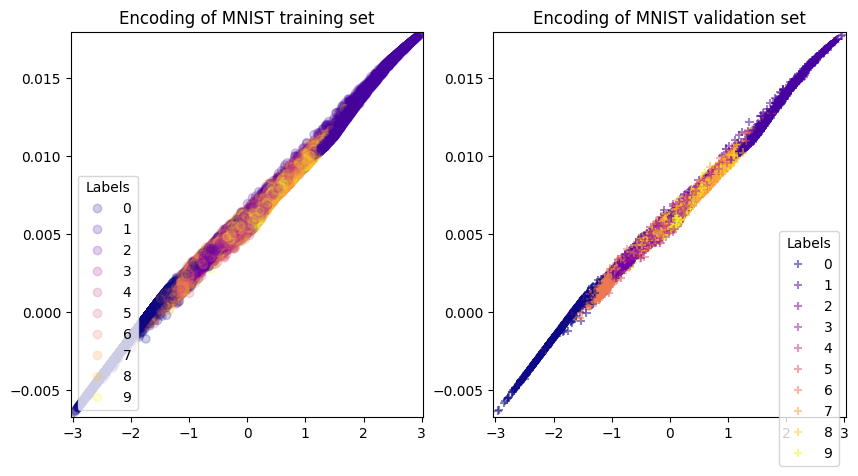

In [36]:
plot_mnist_encoding(vae_model)

The visualization above, especially in constrast to the identical one done for the regular autoencoder shows the impact of the Kullback-Leibler divergence on the distribution of the encoded points in the latent space.

Let's visualize how the entire latent space decodes at once. How can we do that? Well, we can simply sample the latent space with a grid at a given resolution, decode each point into an image using a decoder and plot the mosaic of decoded images to get a full picture of the latent space.

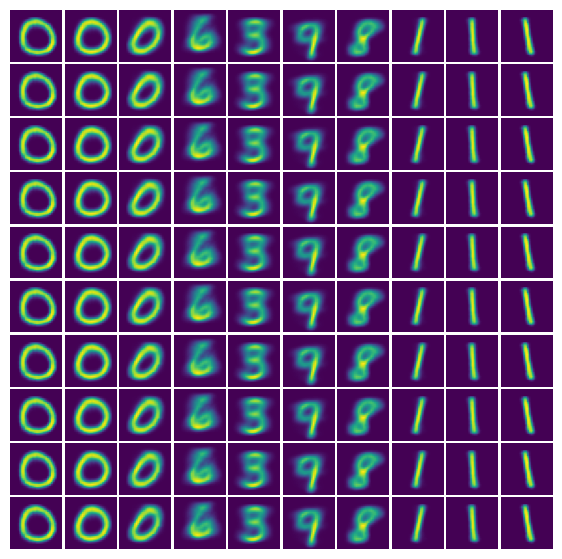

In [37]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We sampled the latent space with a simple evenly-space grid. Is that how we should sample the latent space? Not quite. Indeed, with a VAE, we are trying to constrain our encoded data to fit a normal distribution. That is, we are forcing the encoding to be denser around $[0,0]$ and sparser further away from the origin. If we sample with an evenly-spaced grid, we are not sampling those denser regions as much as we should. The visualization above illustrates this as there is little variation in the decoded samples but at the very center of the mosaic. This is where we'd like to have a denser sampling

It turns out there is a simple solution to this issue: sample in probability space. Instead of sampling at $x$ where $[x=-3,x=-2,x=-1,...]$, we'll sample at $x$ where $[p(x)=0.05, p(x)=0.1, p(x)=0.15,...]$ where $p(x)$ is the cumulative density function (cdf) of the normal distribution (i.e. the probability that a sample from the normal distribution would be smaller than $x$). To find these sampling locations, we can use the inverse of the cdf, i.e. the percent point function (ppf) or quantile function, which is implemented in `scipy`.

This may seem a little esoteric, so let's plot things to shed some light on what this type of sampling translates to. The plot below shows the distribution of points sampled on an evenly-spaced grid and on a grid that is evenly-spaced in probability terms.

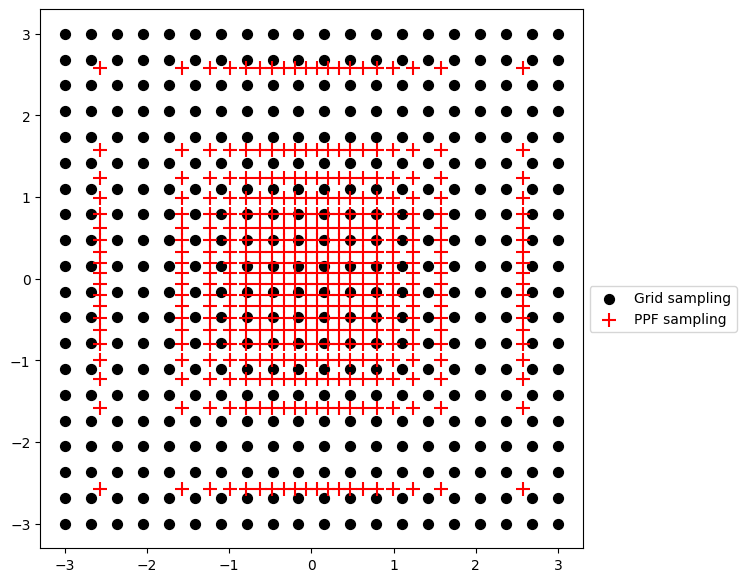

In [38]:
plt.figure(figsize=(7, 7))

n = 20  # sampling resolution
# evenly-spaced grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], s=50, c="black", label="Grid sampling")

z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], marker="+", s=100, c="red", label="PPF sampling")
plt.legend(fontsize=10, bbox_to_anchor=(1, 0.5))
plt.show()

Now, let's use this sampling scheme on the MNIST VAE (with a higher resolution) and see what we get.

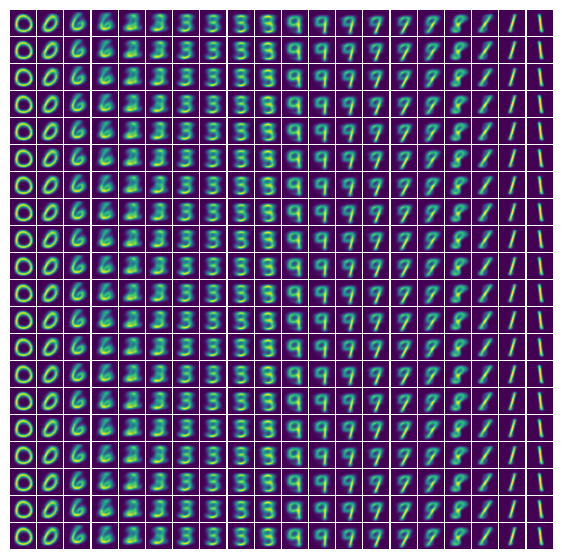

In [39]:
n = 20  # number of images per rows columns

# grid sampling in latent space
z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We're now getting much more detail about what's happening closer to the origin, where most of the action truly is. This plot essentially provides a good snapshot of the spectrum of images the decoder is able to generate/reproduce.

What is pretty remarkable is the ability of the decoder to smoothly interpolate between different digits, for example to produce 1s that almost look like 9s or vice-versa.That is the power of latent variable modeling. And now, imagine those were pictures of designs. You could use the same technique to compress a design space and provide a reduced map of designs just like this. We'll discuss this type of approach this week.

Clearly, it cannot reproduce everything, as we would expect. Such heavy compression is almost inevitably lossy, and in this case, a latent dimensionality of 2 is probably too small. We may be able to push things further by increasing the complexity of the model but we would some limit because we just cannot fit an infinite amount of variation in that small space.

Reducing the size of your latent space almost inevitably means reducing its representational power, but a smaller latent space is also easier to explore, visualize, and exploit for design generation, so this trade-off is often worth it.

Let's build the same plot for the autoencoder to demonstrate the difference between the latent spaces produded. Since they encoding is not constrained to meet any sort of distribution, we'll use regular grid sampling across the bounding box of encoded validation samples.

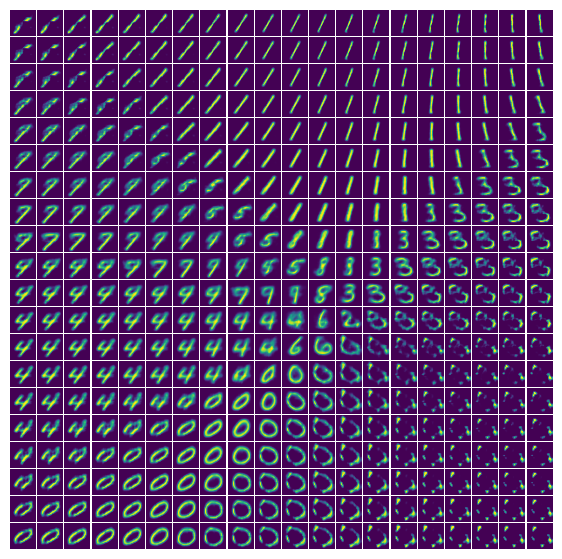

In [40]:
# get bounding box
ae_encodings, _ = get_all_encodings(ae_model, validation_dataloader)
x_min, y_min = np.min(ae_encodings, axis=0)
x_max, y_max = np.max(ae_encodings, axis=0)


n = 20  # number of images per rows columns

# grid sampling in latent space
z1 = np.linspace(0, 1, n) * (x_max - x_min) + x_min
z2 = np.linspace(0, 1, n) * (y_max - y_min) + y_min
Z1, Z2 = np.meshgrid(z1, z2)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = ae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

Clearly, the latent space is not as "nice" as the one produced by the VAE, i.e. most of the space contains little variations and/or garbage.

VAEs offer a very interesting technique for doing some exploration in a reduced dimensional space. Obviously, these examples using MNIST are pretty contrived, however you might imagine that there are other kinds of things you might be interested in interpolating between. What is one use case you can imagine in your own design work for a VAE? Please answer in the markdown cell below. (2 points)

Generating 3D geometries, and rearranging them which can be interpolated between various forms, like a design of table, with many possible iterations. We can even generate photorealistic images of people, flowers, as you had presented during the class.

Congratulations, you have made it to the end of HW2! Please save you changes and then commit and sync them to github. Also, zip the folder for HW2 and upload it to Canvas.